# Quickstart

This is a short tutorial of how to get started with vqc.
We will cut a small circuit both manually and automatically, and then execute the cut circuit on multiple quantum devices.

First, we define a simple 4-qubit circuit:

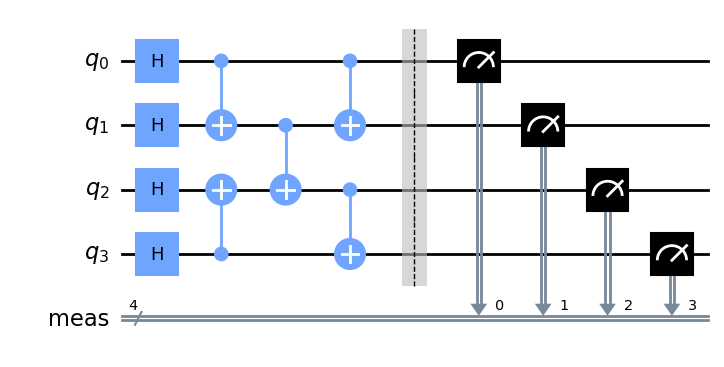

In [1]:
from qiskit import QuantumCircuit
from IPython.display import display

circuit = QuantumCircuit(4)
circuit.h([0, 1, 2, 3])
circuit.cx(0, 1)
circuit.cx(3, 2)
circuit.cx(1, 2)
circuit.cx(0, 1)
circuit.cx(2, 3)
circuit.measure_all()
circuit.draw("mpl")


## Manual Circuit Cutting using `QubitGroups`

Now, let's cut the circuit by dividing the circuit into the top and the bottom 2 qubits. For this we use the `qvm.cut.QubitGroups` cut-pass:

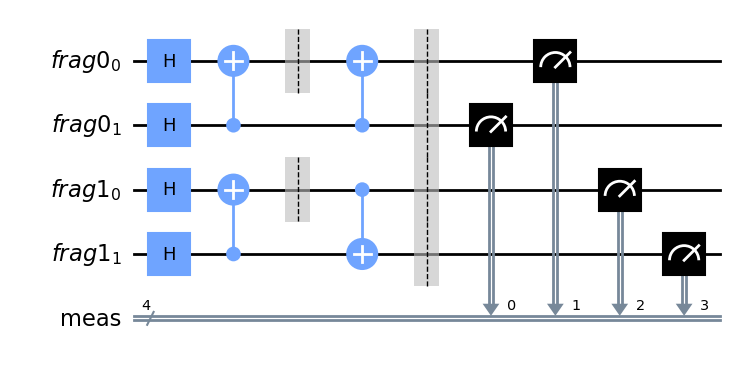

In [2]:
from vqc.cut import cut, QubitGroups

frag1_qubits = {circuit.qubits[0], circuit.qubits[1]}
frag2_qubits = {circuit.qubits[2], circuit.qubits[3]}

cut_circuit = cut(circuit, QubitGroups([frag1_qubits, frag2_qubits]))
cut_circuit.draw("mpl")


As you can see in the circuit's drawing, the circuit is cut by virtualizing the CX-gate between the 2 qubit groups. The virtual gate is visually represented as a barrier.

Now, the dissected circuit consists of 2 fragments (`frag0` and `frag1`) that are represented as `QuantumRegisters`. The fragments can also respectively be converted to circuits:

[Fragment(2, 'frag0'), Fragment(2, 'frag1')]


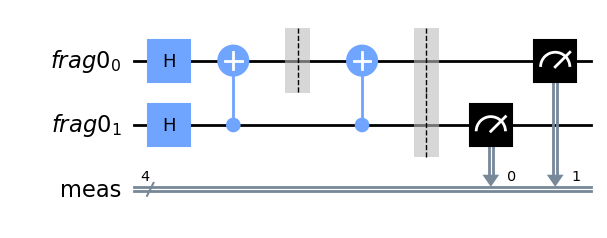

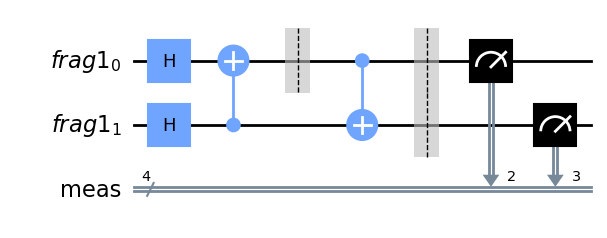

In [3]:
print(cut_circuit.fragments)
for frag in cut_circuit.fragments:
    display(cut_circuit.fragment_as_circuit(frag).draw("mpl"))


## Automatic Circuit Cutting using `Bisection`

Now, let's cut the same circuit using the `qvm.cut.Bisection` cut-pass, which dissects the circuit into 2 equally-sized fragments, while virtualizing the least amount of binary gates. In this case, this will have the same result as the manual cutting from above.

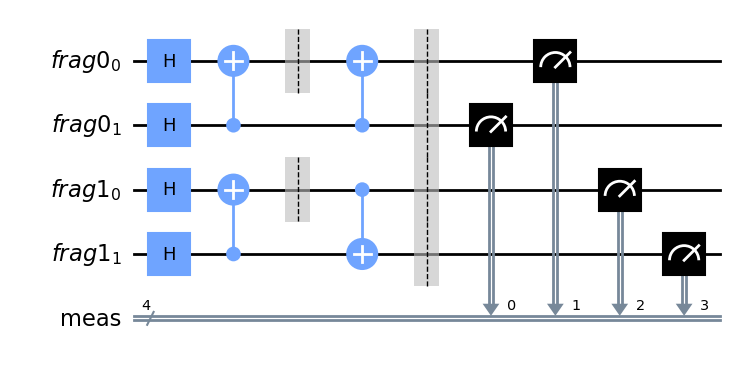

In [4]:
from vqc.cut import Bisection

cut_circuit = cut(circuit, Bisection())
cut_circuit.draw("mpl")


## Executing a Dissected Circuit on Multiple Devices

To execute a cut circuit, we can assign each fragment to a specific quantum device. In this example we use 2 simulator devices. The `qvm.executor.execute` function will handle the distributed execution and the virtualization process of the virtual gates inside the dissected circuit.

In [5]:
from vqc.device import SimDevice
from vqc.executor import execute

device1 = SimDevice()
device2 = SimDevice()

cut_circuit.set_fragment_device(cut_circuit.fragments[0], device1)
cut_circuit.set_fragment_device(cut_circuit.fragments[1], device2)

counts = execute(cut_circuit, shots=1000)
counts

{'0000': 71,
 '0001': 65,
 '0010': 71,
 '0011': 66,
 '0100': 62,
 '0101': 56,
 '0110': 63,
 '0111': 57,
 '1000': 69,
 '1001': 60,
 '1010': 67,
 '1011': 65,
 '1100': 71,
 '1101': 46,
 '1110': 53,
 '1111': 66}

In [6]:
from vqc.bench.fidelity import fidelity

fidelity(circuit, counts)

0.9967578870510462